### Get NBA statistics

In [1]:
import pandas as pd
from nba_api.stats.endpoints import leagueleaders


first_year = 1994
last_year = 2024
leaders_df = []

for year in range(last_year-1, first_year-1, -1):
    season = "{}-{:02}".format(year, (year+1) % 100)
    leaders = leagueleaders.LeagueLeaders(per_mode48="Totals", scope="Rookies", season=season, season_type_all_star="Regular Season")
    leaders_season_df = leaders.get_data_frames()[0]
    leaders_season_df["SEASON"] = season
    leaders_df.append(leaders_season_df.head(100))

leaders_df = pd.concat(leaders_df, ignore_index=True)

### Read targets data from csv

In [2]:
with open('target.csv') as csv_file:
    target_names_df = pd.read_csv(csv_file)
    target_names_df = target_names_df.iloc[-10:, (last_year-2024):(last_year-first_year)]


leaders_df['TARGET'] = 0
for season in target_names_df:
    target_teams = target_names_df[season].to_numpy().reshape(2, 5)

    for team_idx, target_team in enumerate(target_teams):
        idxs = (leaders_df['SEASON'] == season) & leaders_df['PLAYER'].isin(target_team)
        leaders_df.loc[idxs, 'TARGET'] = 2 - team_idx

### Analyze data

In [3]:
leaders_analysis = []
for season in leaders_df['SEASON'].unique():
    season_analysis = leaders_df.loc[leaders_df['SEASON'] == season]['TARGET'].value_counts()
    leaders_analysis.append(season_analysis.rename(season))

leaders_analysis = pd.DataFrame(leaders_analysis)

### Split into train and test data

In [4]:
test_seasons = ['1997-98', '2002-03', '2007-08', '2012-13', '2017-18', '2022-23', '2023-24']

train_df = leaders_df[~leaders_df['SEASON'].isin(test_seasons)].reset_index(drop=True)

test_dfs = []
for season in test_seasons:
    test_dfs.append(leaders_df[leaders_df['SEASON'] == season].reset_index(drop=True))

### Prepare data of features and targets

In [5]:
features = ['GP', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT',
                  'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PTS', 'EFF']

train_data = train_df[features]
train_target = train_df['TARGET'].to_numpy()

test_data, test_target = [], []
for test_df in test_dfs:
    test_data.append(test_df[features])
    test_target.append(test_df['TARGET'].to_numpy())

### Build pipeline and train model

In [6]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import GenericUnivariateSelect, chi2
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler


ops = [('scaler', MinMaxScaler()),
       ('feature_selector', GenericUnivariateSelect(chi2, mode='k_best', param=5)),
       ('model', RandomForestRegressor(random_state=8))]
pipe = Pipeline(ops)

_ = pipe.fit(train_data, train_target)

### Visualize feature selection

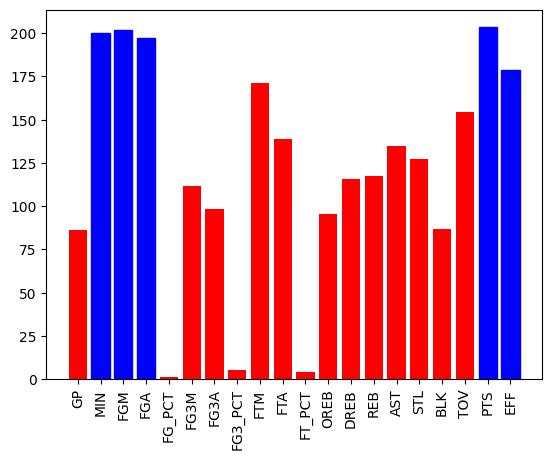

In [7]:
import matplotlib.pyplot as plt


features_selector = pipe.named_steps['feature_selector'].scores_
features_selector_idxs = features_selector.argsort()[-5:]

bar_plot = plt.bar(features, features_selector, color='r')
for feature_idx in features_selector_idxs:
    bar_plot[feature_idx].set_color('b')

plt.xticks(rotation=90)
plt.show()

### Visualize features data

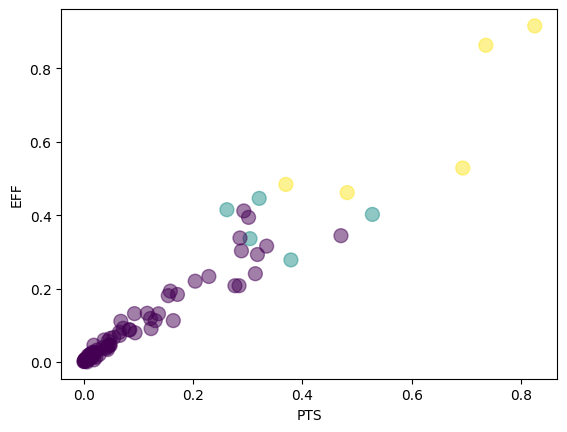

In [8]:
test_season_idx = -1
feature_1 = 'PTS'
feature_2 = 'EFF'

test_data_norm = pipe.named_steps['scaler'].transform(test_data[test_season_idx])
plt.scatter(test_data_norm[:, features.index(feature_1)],
            test_data_norm[:, features.index(feature_2)],
            c=test_target[test_season_idx], s=100, alpha=0.5)
plt.xlabel(feature_1)
plt.ylabel(feature_2)
plt.show()

### Test model

In [9]:
import numpy as np


for test_idx, test_df in enumerate(test_dfs):
    predictions = pipe.predict(test_data[test_idx])
    test_df['PRED_VAL'] = predictions

    prediction_idxs = np.argsort(predictions)[::-1]

    test_df['PRED_TARGET'] = 0
    test_df.loc[prediction_idxs[:5], 'PRED_TARGET'] = 2
    test_df.loc[prediction_idxs[5:10], 'PRED_TARGET'] = 1

### Calculate predictions score

In [10]:
for test_df in test_dfs:
    test_df['SCORE'] = 0
    pts = [10, 8]
    bonus_val = [0, 0, 5, 10, 20, 40]
    team_bonuses = [0, 0]

    for idx, player in test_df.iterrows():
        if player['TARGET'] != 0 and player['PRED_TARGET'] != 0:
            error = int(abs(player['TARGET'] - player['PRED_TARGET']))
            test_df.loc[idx, 'SCORE'] = pts[error]

            if error == 0:
                team_bonuses[int(player['TARGET']-1)] += 1

    scores = test_df['SCORE'].to_numpy()
    bonus = sum([bonus_val[team_bonus] for team_bonus in team_bonuses])

    total_score = np.sum(scores) + bonus

    print('Season:', test_df['SEASON'].iloc[0])
    print('Score:', total_score, '\n')


Season: 1997-98
Score: 116 

Season: 2002-03
Score: 66 

Season: 2007-08
Score: 101 

Season: 2012-13
Score: 97 

Season: 2017-18
Score: 150 

Season: 2022-23
Score: 82 

Season: 2023-24
Score: 101 



### Analyse predictions

In [11]:
test_dfs[-1][['PLAYER', 'TARGET', 'PRED_TARGET', 'SCORE']].sort_values(by=['TARGET', 'SCORE'], ascending=False).head(10)

,PLAYER,TARGET,PRED_TARGET,SCORE
0,Victor Wembanyama,2,2,10
1,Chet Holmgren,2,2,10
2,Brandon Miller,2,2,10
4,Jaime Jaquez Jr.,2,2,10
7,Brandin Podziemski,2,1,8
9,Amen Thompson,1,1,10
19,Dereck Lively II,1,1,10
3,Keyonte George,1,2,8
6,GG Jackson,1,0,0
12,Cason Wallace,1,0,0
